<span style="font-weight:bold; font-size:20px;">Import</span>

In [39]:
import pandas as pd
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import copy
from datetime import datetime
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor, as_completed
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.feature_selection import RFE
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import precision_score, recall_score, roc_auc_score

<span style="font-weight:bold; font-size:20px;">All function</span>

In [2]:
# Data preprocessing
def data_pre(companies):
    for i in companies:
        if 'metadata' in i.keys():
            del i['metadata']
        comp_name = i['name']
        i['name'] = f"{comp_name}_{companies.index(i)}"
        if not isinstance(i['equity_funding_total_usd'], int):
            value = i['equity_funding_total_usd']
            i['equity_funding_total_usd'] = int(value['$numberLong'])
        if i['num_funding_rounds'] is None:
            i['num_funding_rounds'] = 0
    return companies

In [30]:
# The criteria to judge whether the company is successful
def whether_success(companies):
    for i in companies:
        i['startup'] = 'failed'
        if i['operating_status'] != 'closed':
            if i['went_public_on']:
                i['startup'] = 'success'
            elif i['status'] == 'was_acquired' or i['status'] == 'ipo':
                i['startup'] = 'success'
            elif i['num_acquisitions']:
                i['startup'] = 'success'
            # elif (datetime.now() - datetime.strptime(i['founded_on'], '%Y-%m-%d')).days/365 >= 7:
            #     i['startup'] = 'success'
            # elif i['num_funding_rounds'] >= 7:
            #     i['startup'] = 'success'
            elif i['equity_funding_total_usd'] >= 100000000:
                i['startup'] = 'success'
            elif i['revenue_range'] is not None:
                i['startup'] = 'success'
    return companies

In [4]:
# Network building
def build_nw(comps, peo):
    G = nx.Graph()
    G.add_nodes_from(comps)
    
    peo_dict = {comp: set(p) for comp, p in zip(comps, peo)}
    
    def process_pairs(i, comp):
        edges = []
        for j in range(i+1, len(comps)):
            same = peo_dict[comp] & peo_dict[comps[j]]
            if same:
                edges.append((comp, comps[j], len(same)))
        return edges

    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(process_pairs, i, comp) for i, comp in enumerate(comps)]
        for future in as_completed(futures):
            for comp1, comp2, weight in future.result():
                if G.has_edge(comp1, comp2):
                    G[comp1][comp2]['weight'] += weight
                else:
                    G.add_edge(comp1, comp2, weight=weight)

    return G

In [5]:
# Calculate success rate
def success_rate(data, dict, field):
    result = {}
    for i in dict:
        result[i] = 0
        for n in data:
            if isinstance(n[field], list):
                if i in n[field] and n['startup'] == 'success':
                    result[i] += 1
            else:
                if n[field] == i and n['startup'] == 'success':
                    result[i] += 1
    for k in result:
        result[k] = result[k]/dict[k]
    return result

In [6]:
# Calculate component data
def components_data(G):
    result = {}
    for component in nx.connected_components(G):
        subgraph = G.subgraph(component)
        sub_size = len(subgraph)
        sub_success = 0
        for node in subgraph:
            if G.nodes[node]['success'] == 'success':
                sub_success += 1
        sub_success_rate = sub_success/sub_size
        density = nx.density(subgraph)
        for node in subgraph:
            result[node] = {'component_size': sub_size, 'component_success_rate': sub_success_rate, 'component_score':sub_success_rate * density}
    return result

In [53]:
# Basic analysis of the whole network
def generate_data(G):
    net_nodes = len(G.nodes())
    net_edges = len(G.edges())
    net_den = round(nx.density(G),4)
    avg_cluster = round(nx.average_clustering(G),4)
    avg_degree = round(np.mean(list(dict(G.degree()).values())),4)
    max_degree = max(list(dict(G.degree()).values()))
    min_degree = min(list(dict(G.degree()).values()))
    # total_strength = 0
    # for node in G.nodes():
    #     node_strength = sum(data["weight"] for u, v, data in G.edges(node, data=True))
    #     total_strength += node_strength
    # avg_strength = round(total_strength / net_nodes, 4)
    try:
        net_assortativity = round(nx.degree_assortativity_coefficient(G),4)
    except RuntimeWarning:
        net_assortativity = None

    table ={
        "Number of Nodes": net_nodes,
        "Number of Edges": net_edges,
        "Density": net_den,
        "Avg Clustering Coefficient": avg_cluster,
        "Avg Degree": avg_degree,
        "Max Degree": max_degree,
        "Min Degree": min_degree,
        # "Avg Strength": avg_strength,
        "Assortativity": net_assortativity}    
    return table

In [8]:
# Generate the features
def generate_feature(G, data):
    degrees = dict(G.degree())
    # clustering = nx.clustering(G)
    closeness = nx.closeness_centrality(G)
    # betweenness = nx.betweenness_centrality(G)
    # eigenvector_centrality = nx.eigenvector_centrality(G)
    # pagerank = nx.pagerank(G)
    
    nodes = [i['name'] for i in data]
    fea_info = {
        'node_id': nodes,
        'degree': [degrees[node] for node in nodes],
        # 'clustering': [clustering[node] for node in nodes],
        'closeness': [closeness[node] for node in nodes],
        # 'betweenness': [betweenness[node] for node in nodes],
        # 'closeness': [closeness[node] for node in nodes],
        # 'eigenvector_centrality': [eigenvector_centrality[node] for node in nodes],
        # 'pagerank': [pagerank[node] for node in nodes],
        'categories': [i['category_groups'] for i in data]
    }
    df = pd.DataFrame(fea_info)
    return df

In [9]:
# Generate neighbors data
def neighbors_score(G, nodes):
    neighbors_sco = []
    for node in nodes:
        score = 0
        neighbors = G.neighbors(node)
        for neighbor in neighbors:
            neighbor_status = G.nodes[neighbor]['success']
            edge_weight = G[node][neighbor]['weight']
            if neighbor_status == 'success':
                score += edge_weight
            elif neighbor_status == 'failed':
                score -= edge_weight
        neighbors_sco.append(score)
    return neighbors_sco

In [10]:
# Show the result
def evaluate_pred(model, X_test, y_test, y_pred, model_name):
    y_proba = model.predict_proba(X_test)[:, 1]
    print(f"{model_name} Classification Report:")
    print(classification_report(y_test, y_pred))
    
    if y_proba is not None:
        roc_auc = roc_auc_score(y_test, y_proba)
        print(f"{model_name} ROC AUC Score: {roc_auc:.3f}")
    else:
        print(f"{model_name} does not provide probability predictions for ROC AUC Score.")

<span style="font-weight:bold; font-size:20px;">Data loading and preprocessing</span>

In [11]:
file = '/Users/kiening/Documents/Dissertation/dissertation.cb_companies.json'

with open(file, 'r', encoding='utf-8') as file:
    data = json.load(file)


In [12]:
data = whether_success(data_pre(data))

In [31]:
data = whether_success(data)

<span style="font-weight:bold; font-size:20px;">Network building</span>

In [13]:
comps = []
peo = []

for i in data:
    comps.append(i['name'])
    peo.append(list(set(i['founders']) | set(i['investors'])))

In [14]:
G = build_nw(comps, peo)

In [75]:
# Draw LCC here
largest_cc = max(nx.connected_components(G), key=len)
subgraph = G.subgraph(largest_cc)

pos = nx.spring_layout(subgraph, seed=42)
plt.figure(figsize=(8, 6))
nx.draw(subgraph, pos, with_labels=False, node_color='skyblue', node_size=700, edge_color='gray', width=2)
edge_labels = nx.get_edge_attributes(subgraph, 'weight')
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_size=12, font_color='red')

plt.title("Network - Largest Connected Component", fontsize=16)
plt.axis('off')
plt.show()

KeyboardInterrupt: 

In [15]:
node_attri = {}
for index, node in enumerate(G.nodes()):
    node_attri[node] = {}
    node_attri[node]['name'] = data[index]['name']
    node_attri[node]['categories'] = data[index]['category_groups']
    node_attri[node]['success'] = data[index]['startup']
nx.set_node_attributes(G, node_attri)

In [95]:
largest_cc = max(nx.connected_components(G), key=len)
subgraph = G.subgraph(largest_cc)

In [97]:
len(subgraph.nodes())

68256

<span style="font-weight:bold; font-size:20px;">Basic analysis of the whole network</span>

In [16]:
analysis = generate_data(G)
analysis

{'Number of Nodes': 300001,
 'Number of Edges': 13487896,
 'Density': 0.0003,
 'Avg Clustering Coefficient': 0.2284,
 'Avg Degree': 89.919,
 'Max Degree': 5033,
 'Min Degree': 0,
 'Avg Strength': 91.8461,
 'Assortativity': 0.6934}

In [54]:

num_nodes = 300001
num_edges = 13487896

m = num_edges // num_nodes

G_test = nx.barabasi_albert_graph(n=num_nodes, m=m)

ana_test = generate_data(G_test)
ana_test

{'Number of Nodes': 300001,
 'Number of Edges': 13198108,
 'Density': 0.0003,
 'Avg Clustering Coefficient': 0.0022,
 'Avg Degree': 87.9871,
 'Max Degree': 6156,
 'Min Degree': 44,
 'Assortativity': -0.0008}

<span style="font-weight:bold; font-size:20px;">Isolated nodes</span>

In [17]:
isolates = list(nx.isolates(G))
iso_comps = []
found_on = []
funding = []
rounds = []
startup = []
for i in range(len(unique_comps)):
    if unique_comps[i] in isolates:
        iso_comps.append(data[i]['name'])
        found_on.append((datetime.now() - datetime.strptime(data[i]['founded_on'], '%Y-%m-%d')).days)
        funding.append(data[i]['equity_funding_total_usd'])
        rounds.append(data[i]['num_funding_rounds'])
        startup.append(data[i]['startup'])
iso_df = pd.DataFrame({
    'company': iso_comps,
    'days_since_founded': found_on,
    'equity_funding_total_usd': funding,
    'num_funding_rounds': rounds,
    'startup': startup
})
iso_df['num_funding_rounds'] = iso_df['num_funding_rounds'].fillna(0)

NameError: name 'unique_comps' is not defined

In [79]:
# Use Random forests to judge feature importance
X = iso_df.drop(columns=['startup', 'company'])
y = iso_df['startup']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalized
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Feature importance
feature_importances = model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Rank
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [ ]:
# Feature combination
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

model_poly = RandomForestClassifier(random_state=42)
model_poly.fit(X_train_poly, y_train)

# Performance
y_pred = model_poly.predict(X_test_poly)
print("Classification Report with Interaction Features:")
print(classification_report(y_test, y_pred))

<span style="font-weight:bold; font-size:20px;">Non-isolated nodes</span>

In [32]:
data_non_iso = [i for i in data if i['name'] not in isolates]

In [18]:
# Generate the feature dataframe
data_non_iso = [i for i in data if i['name'] not in isolates]
fea_df = generate_feature(G, data_non_iso)

In [19]:
# Caculate the class success rate and closeness
cla = {}
for i in data_non_iso:
    for n in i['category_groups']:
        if not n in cla.keys():
            cla[n] = 1
        else:
            cla[n] += 1
cla_success_rate = success_rate(data_non_iso, cla, 'category_groups')
cla_avg_closeness = {}
for i in cla.keys():
    for n in range(len(fea_df['node_id'])):
        if i in fea_df['categories'][n]:
            if i in cla_avg_closeness:
                cla_avg_closeness[i] += fea_df['closeness'][n]
            else:
                cla_avg_closeness[i] = fea_df['closeness'][n]
for i in cla_avg_closeness:
    cla_avg_closeness[i] = cla_avg_closeness[i]/cla[i]


avg_cla_sco = []
avg_cla_clo = []
for i in fea_df['categories']:
    cla_rates = [cla_success_rate[n] for n in i]
    clo_rates = [cla_avg_closeness[n] for n in i]
    if cla_rates:
        avg_success_rate = sum(cla_rates) / len(cla_rates)
        avg_clo = sum(clo_rates) / len(clo_rates)
        avg_cla_sco.append(avg_success_rate)
        avg_cla_clo.append(avg_clo)
    else:
        avg_cla_sco.append(0)
        avg_cla_clo.append(0)
fea_df['class_score'] = avg_cla_sco
fea_df['class_avg_closeness'] = avg_cla_clo

In [20]:
# Caculate the location success rate
location = {}
for i in data_non_iso:
    if i['location_groups']:
        for n in i['location_groups']:
            if not n in location:
                location[n] = 1
            else:
                location[n] += 1
loc_success_rate = success_rate(data_non_iso, location, 'location_groups')
avg_loc_sco = []
for i in data_non_iso:
    rates = [loc_success_rate[n] for n in i['location_groups']]
    if rates:
        avg_success_rate = sum(rates) / len(rates)
        avg_loc_sco.append(avg_success_rate)
    else:
        avg_loc_sco.append(0)
fea_df['location_score'] = avg_loc_sco

In [21]:
# Caculate the number of employees success rate
employees = {}
for i in data_non_iso:
    if i['num_employees_enum']:
        if not i['num_employees_enum'] in employees:
            employees[i['num_employees_enum']] = 1
        else:
            employees[i['num_employees_enum']] += 1
emp_success_rate = success_rate(data_non_iso, employees, 'num_employees_enum')
avg_emp_sco = []
for i in data_non_iso:
    if i['num_employees_enum']:
        avg_emp_sco.append(emp_success_rate[i['num_employees_enum']])
    else:
        avg_emp_sco.append(0)
fea_df['employees_score'] = avg_emp_sco

In [22]:
# Caculate component data
node_component_data = components_data(G)
comp_success_rate = [node_component_data[node]['component_success_rate'] for node in fea_df['node_id']]
comp_size = [node_component_data[node]['component_size'] for node in fea_df['node_id']]
comp_sco = [node_component_data[node]['component_score'] for node in fea_df['node_id']]
fea_df['component_success_rate'] = comp_success_rate
fea_df['component_size'] = comp_size
fea_df['component_score'] = comp_sco

In [23]:
# Caculate neighbors_data
neighbors_data = neighbors_score(G, fea_df['node_id'])
fea_df['neighbors_weighted_success'] = neighbors_data

In [24]:
fea_df

,node_id,degree,closeness,categories,class_score,class_avg_closeness,location_score,employees_score,component_success_rate,component_size,component_score,neighbors_weighted_success
0,Gro Intelligence_0,292,0.109160,"[Agriculture and Farming, Artificial Intellige...",0.607058,0.085842,0.602748,0.794588,0.625197,95026,0.001866,134
1,Squire_1,1886,0.119097,"[Apps, Commerce and Shopping, Mobile, Other, S...",0.611458,0.082606,0.602748,0.794588,0.625197,95026,0.001866,-22
2,The EVERY Company_2,341,0.110263,"[Biotechnology, Food and Beverage, Health Care...",0.635042,0.088037,0.593158,0.794588,0.625197,95026,0.001866,87
3,Groq_3,963,0.114926,"[Artificial Intelligence (AI), Consumer Electr...",0.624526,0.088110,0.597504,0.794588,0.625197,95026,0.001866,268
4,Campus_4,222,0.106323,"[Education, Software]",0.618667,0.082744,0.594604,0.632183,0.625197,95026,0.001866,31
...,...,...,...,...,...,...,...,...,...,...,...,...
107397,Easy Resume_299962,1,0.073628,"[Administrative Services, Professional Service...",0.624443,0.081339,0.602748,0.546497,0.625197,95026,0.001866,-1
107398,Worth Wearing_299969,6,0.083942,"[Content and Publishing, Media and Entertainment]",0.644531,0.077744,0.613672,0.546497,0.625197,95026,0.001866,2
107399,Right Start Newcomer Services_299972,19,0.000063,"[Education, Media and Entertainment, Software]",0.625400,0.081386,0.000000,0.546497,0.600000,20,0.600000,5
107400,OrangeNow_299980,3,0.084703,"[Commerce and Shopping, Food and Beverage, Int...",0.624207,0.080766,0.593158,0.546497,0.625197,95026,0.001866,4


<span style="font-weight:bold; font-size:20px;">Training and prediction</span>

In [33]:
# Split the data
X = fea_df.drop(columns=['node_id', 'categories', 'component_success_rate', 'component_size'])
y = [i['startup'] for i in data_non_iso]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
# Normalize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [35]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Feature importance
feature_importances = model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Rank
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

                      Feature  Importance
1                   closeness    0.192600
3         class_avg_closeness    0.173222
2                 class_score    0.172061
4              location_score    0.130233
0                      degree    0.119653
7  neighbors_weighted_success    0.118335
5             employees_score    0.080407
6             component_score    0.013489


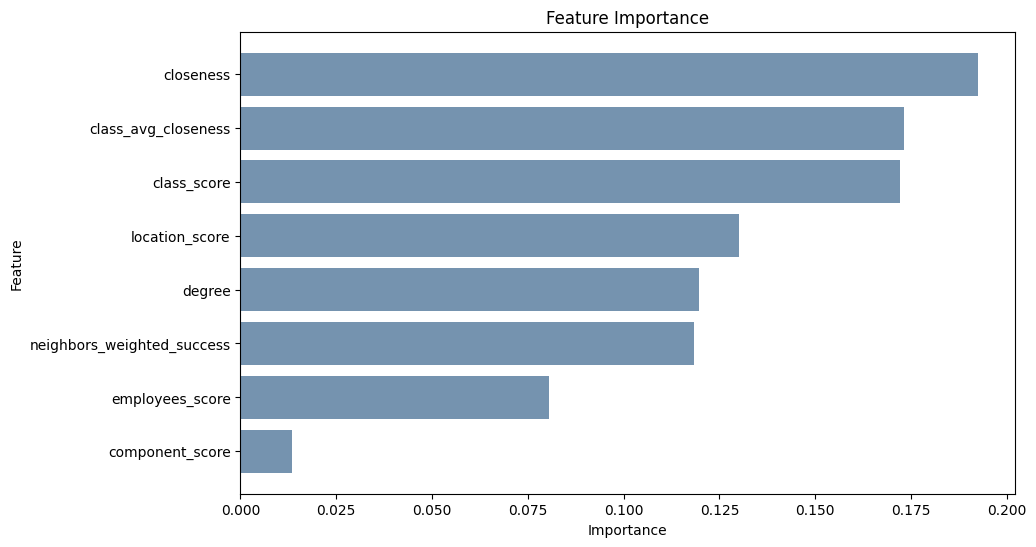

In [51]:
features = importance_df['Feature']
importances = importance_df['Importance']

# 创建条形图
plt.figure(figsize=(10, 6))
plt.barh(features, importances, color='#7593af')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # 将最高的重要性值显示在顶部
plt.show()

In [36]:
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

model_1 = LogisticRegression(class_weight='balanced', max_iter=10000)
model_2 = DecisionTreeClassifier()
model_3 = RandomForestClassifier()
model_4 = SVC(kernel='linear', probability=True)
model_5 = KNeighborsClassifier(n_neighbors=3)

model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)
model_4.fit(X_train, y_train)
model_5.fit(X_train, y_train)

y_pred_1 = model_1.predict(X_test)
y_pred_2 = model_2.predict(X_test)
y_pred_3 = model_3.predict(X_test)
y_pred_4 = model_4.predict(X_test)
y_pred_5 = model_5.predict(X_test)

model_1_poly = LogisticRegression()
model_2_poly = DecisionTreeClassifier()
model_3_poly = RandomForestClassifier()
model_4_poly = SVC(kernel='linear', probability=True)
model_5_poly = KNeighborsClassifier(n_neighbors=3)

model_1_poly.fit(X_train_poly, y_train)
model_2_poly.fit(X_train_poly, y_train)
model_3_poly.fit(X_train_poly, y_train)
model_4_poly.fit(X_train_poly, y_train)
model_5_poly.fit(X_train_poly, y_train)

y_pred_1_poly = model_1_poly.predict(X_test_poly)
y_pred_2_poly = model_2_poly.predict(X_test_poly)
y_pred_3_poly = model_3_poly.predict(X_test_poly)
y_pred_4_poly = model_4_poly.predict(X_test_poly)
y_pred_5_poly = model_5_poly.predict(X_test_poly)

/Users/kiening/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [37]:
evaluate_pred(model_1, X_test, y_test, y_pred_1, 'Logistic Regression')
evaluate_pred(model_2, X_test, y_test, y_pred_2, 'Decision Tree')
evaluate_pred(model_3, X_test, y_test, y_pred_3, 'Random Forest')
evaluate_pred(model_4, X_test, y_test, y_pred_4, 'SVC')
evaluate_pred(model_5, X_test, y_test, y_pred_5, 'K-Nearest Neighbors')
print('*******************************************')
evaluate_pred(model_1_poly, X_test_poly, y_test, y_pred_1_poly, 'Logistic Regression with Interaction Features')
evaluate_pred(model_2_poly, X_test_poly, y_test, y_pred_2_poly, 'Decision Tree with Interaction Features')
evaluate_pred(model_3_poly, X_test_poly, y_test, y_pred_3_poly, 'Random Forest with Interaction Features')
evaluate_pred(model_4_poly, X_test_poly, y_test, y_pred_4_poly, 'SVC with Interaction Features')
evaluate_pred(model_5_poly, X_test_poly, y_test, y_pred_5_poly, 'K-Nearest Neighbors with Interaction Features')

Logistic Regression Classification Report:
              precision    recall  f1-score   support

      failed       0.61      0.59      0.60      9631
     success       0.67      0.69      0.68     11850

    accuracy                           0.64     21481
   macro avg       0.64      0.64      0.64     21481
weighted avg       0.64      0.64      0.64     21481

Logistic Regression ROC AUC Score: 0.695
Decision Tree Classification Report:
              precision    recall  f1-score   support

      failed       0.57      0.58      0.58      9631
     success       0.65      0.64      0.65     11850

    accuracy                           0.61     21481
   macro avg       0.61      0.61      0.61     21481
weighted avg       0.62      0.61      0.61     21481

Decision Tree ROC AUC Score: 0.611
Random Forest Classification Report:
              precision    recall  f1-score   support

      failed       0.66      0.61      0.63      9631
     success       0.70      0.74      0.72 

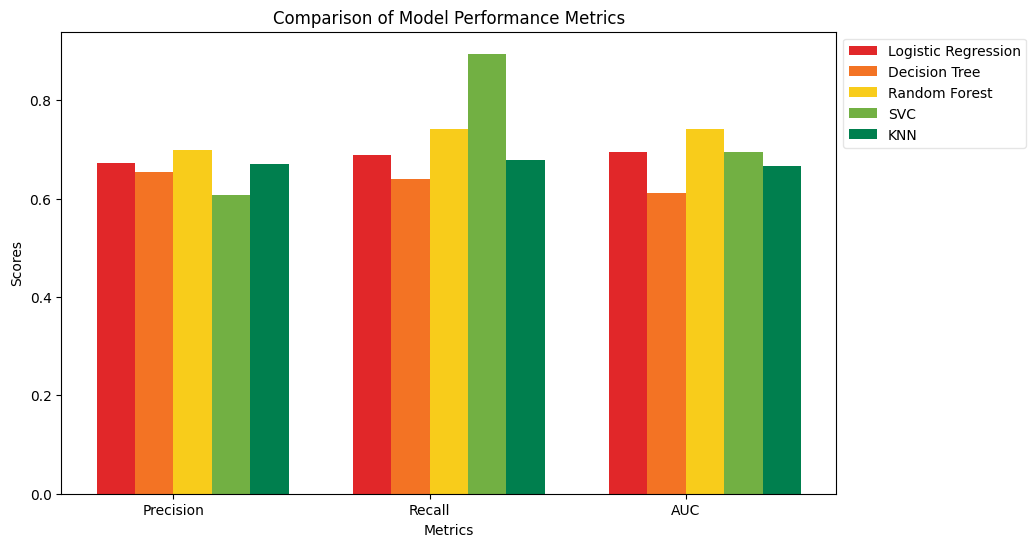

In [46]:
y_pred_proba_1 = model_1.predict_proba(X_test)[:, 1]
y_pred_proba_2 = model_2.predict_proba(X_test)[:, 1]
y_pred_proba_3 = model_3.predict_proba(X_test)[:, 1]
y_pred_proba_4 = model_4.predict_proba(X_test)[:, 1]
y_pred_proba_5 = model_5.predict_proba(X_test)[:, 1]

metrics_1 = [precision_score(y_test, y_pred_1, pos_label = 'success'), recall_score(y_test, y_pred_1, pos_label = 'success'), roc_auc_score(y_test, y_pred_proba_1)]
metrics_2 = [precision_score(y_test, y_pred_2, pos_label = 'success'), recall_score(y_test, y_pred_2, pos_label = 'success'), roc_auc_score(y_test, y_pred_proba_2)]
metrics_3 = [precision_score(y_test, y_pred_3, pos_label = 'success'), recall_score(y_test, y_pred_3, pos_label = 'success'), roc_auc_score(y_test, y_pred_proba_3)]
metrics_4 = [precision_score(y_test, y_pred_4, pos_label = 'success'), recall_score(y_test, y_pred_4, pos_label = 'success'), roc_auc_score(y_test, y_pred_proba_4)]
metrics_5 = [precision_score(y_test, y_pred_5, pos_label = 'success'), recall_score(y_test, y_pred_5, pos_label = 'success'), roc_auc_score(y_test, y_pred_proba_5)]

metrics_names = ['Precision', 'Recall', 'AUC']
index = np.arange(len(metrics_names))

bar_width = 0.15

plt.figure(figsize=(10, 6))
plt.bar(index, metrics_1, bar_width, label='Logistic Regression', color='#e12729')
plt.bar(index + bar_width, metrics_2, bar_width, label='Decision Tree', color='#f37324')
plt.bar(index + 2 * bar_width, metrics_3, bar_width, label='Random Forest', color='#f8cc1b')
plt.bar(index + 3 * bar_width, metrics_4, bar_width, label='SVC', color='#72b043')
plt.bar(index + 4 * bar_width, metrics_5, bar_width, label='KNN', color='#007f4e')


plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Comparison of Model Performance Metrics')
plt.xticks(index + 1.5 * bar_width, metrics_names)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), framealpha=0.5)

plt.show()